Предметом исследования являются данные о пассажирах Титаника.
Цель данной работы: определить параметры которые в большей степени могут повлиять на выживаемость пассажиров.

### Context

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим и посмотрим, что получили:

In [10]:
data = pd.read_csv("./data/train.csv", parse_dates=True)
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
5,5,0,2,"Sassano, Jonathan",male,35.00,0,0,13363,6.71,NaN,S
6,6,0,3,"Conway, Jose",male,7.00,0,0,A/5,9.77,NaN,S
7,7,1,3,"Werner, Linda",female,6.00,1,2,434426,31.50,NaN,S
8,8,0,1,"Wardlaw, Michael",male,27.00,2,1,474849,73.02,A7253,S
9,9,0,2,"Greigo, Rudy",male,66.00,0,0,6981,9.14,D2969,C


In [31]:
data.shape

(100000, 12)

Я думал на Титанике было тысячи 3 человек, а не 100 тыс.

### Data quality assessment

Посмотрим есть ли дубликаты по 'Survived', 'Pclass','Name','Sex','Age','SibSp','Parch','Ticket'

In [75]:
data[data[['Survived', 'Pclass','Name','Sex','Age','SibSp','Parch','Ticket']].duplicated()].groupby('Name').size()


Series([], dtype: int64)

Пока дубликатов нет. Но если убрать Ticket и далее, то они начинают появляться

In [116]:
df = data[['Name','Sex','Age']]
df[df.duplicated()].shape[0]

292

292 - будем считать что это тезки в кубе, и не будем от них избавляться.

Посмотрим на отсутствующие данные. В предоставленных данных часть отсутствующей информации была отмечена символом NaN. Но возможно среди символьных есть пропуски, которые не были отмечены NaN.

In [28]:
data[['Name', 'Sex', 'Ticket', 'Cabin']].apply(lambda x: x == '').sum()

Name      0
Sex       0
Ticket    0
Cabin     0
dtype: int64

Так, пропусков нет, можно посмотреть сколько всего имеем пропущенных данных. Для графического представления воспользуемся heatmap

<AxesSubplot:>

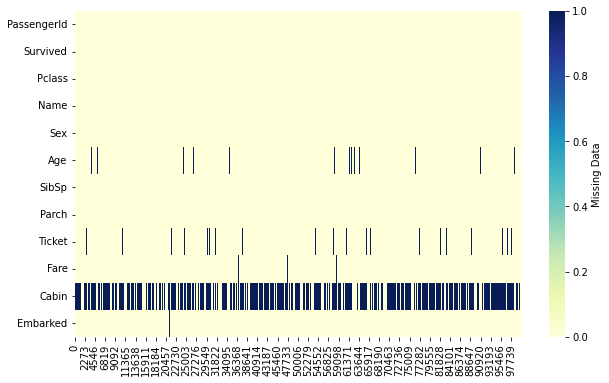

In [33]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [41]:
data.apply(lambda x: pd.isna(x)).sum()*100/data.shape[0]

PassengerId     0.000
Survived        0.000
Pclass          0.000
Name            0.000
Sex             0.000
Age             3.292
SibSp           0.000
Parch           0.000
Ticket          4.623
Fare            0.134
Cabin          67.866
Embarked        0.250
dtype: float64

Таким образом пропущенно около 4% данных в переменной Age, 5% в переменной Ticket и почти 68% в Cabin. И если с возрастом пассажиров и стоимостью билета можно провести обоснованное замещение пропущенных значений средним по классу, в связи с небольшой их долей, то с каютами такое не получится сделать, т.к. пропущенных значений существенно больше нежели заполненных. Пропущенные значения в признаке Embarked заменим на наиболее часто встречающееся место посадки.


In [44]:
data['Embarked'].value_counts()

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64

Наиболее часто встречающееся место посадки - 'S'.

Возраст возьмем не средний по набору, а средний по каждому классу каюты, так как скорее всего в более дорогом классе ехали более состоятельные люди, а в более дешевом молодые - которые хотели эмигрировать в Америку и соответственно имевшие меньше денежных средств.
Еслибы в поле Name имелся гоноратив то тогда можно было заменить на среднее в зависимости от гоноратива, но такого поля нет.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

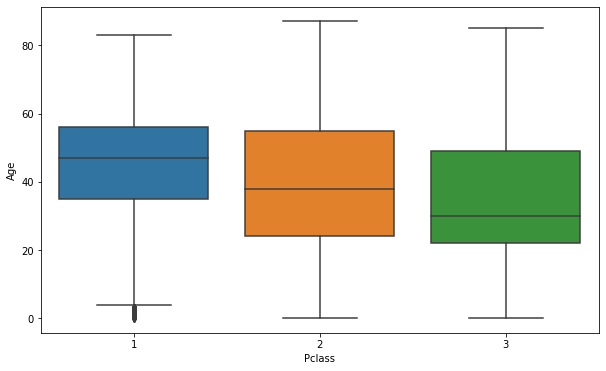

In [120]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Pclass", y="Age", data=data)


In [48]:
data.groupby('Pclass')['Age'].mean()


Pclass
1    44.774464
2    38.631237
3    33.407362
Name: Age, dtype: float64

Средний возраст по классам - 45, 39, 33 соответственно.

Так же воспрос с Ticket их вроде и не много но если посмотреть на распределение:

In [45]:
data['Ticket'].value_counts()

A/5             602
C.A.            177
SC/PARIS        145
SOTON/O.Q.       80
SC               57
               ... 
421812            1
PC 420601         1
PC 26800          1
STON/O 23755      1
458074            1
Name: Ticket, Length: 75331, dtype: int64

Явной закономерности в их содержании найти трудно, поэтому мы просто не будем пока использовать данный параметр.
И так обновим наши данные с учетом выше указанных выводов и предположений.

### Data exploration

A/5             602
C.A.            177
SC/PARIS        145
SOTON/O.Q.       80
SC               57
               ... 
421812            1
PC 420601         1
PC 26800          1
STON/O 23755      1
458074            1
Name: Ticket, Length: 75331, dtype: int64

### Summary